### Imports

In [28]:
import os

from tqdm import tqdm
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import pprint
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
import networkx as nx
from sklearn.metrics import pairwise_distances

from src.evaluation.model_utils import get_latents
from src.models.spike_vae_module import SpikeSortingVAE
from src.evaluation.cluster import clustering_analysis

### Data

In [3]:
REPO_PATH = "/Users/johnzhou/research/spike-sorting"
cluster_fname = f"{REPO_PATH}/data/processed/clusters_k=20/templates.npy"
cluster_templates = np.load(cluster_fname)
cluster_labels = np.load(f"{REPO_PATH}/data/processed/clusters_k=20/unit_idxs.npy")

In [6]:
vae_model = f'{REPO_PATH}/experiments/vae/vae_6latent/model-v1.ckpt'
lat = get_latents(SpikeSortingVAE, vae_model, cluster_fname)
print(lat.shape)

(20000, 6)


### Pre-split

In [ ]:
import time

dist = 10
n_samples = lat.shape[0]
G = nx.Graph()
G.add_nodes_from(range(n_samples))

spike_dists = pairwise_distances(lat)

for i in tqdm(range(n_samples)):
    for j in range(i + 1, n_samples):
        if spike_dists[i, j] < dist:
            G.add_edge(i, j)

  1%|▏                                      | 102/20000 [00:08<28:16, 11.73it/s]

### Clustering

In [23]:
templates = cluster_templates
clusters = cluster_labels

# Map cluster indices to new numbers
cluster_map = dict(zip(list(np.unique(templates)), list(range(20))))
clusters = np.vectorize(cluster_map.get)(clusters)

In [27]:
km = KMeans(n_clusters=20, random_state=4995).fit(lat)
# ari = adjusted_rand_score(km.labels_, clusters)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.003s...
[t-SNE] Computed neighbors for 2000 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.090836
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.915874
[t-SNE] KL divergence after 1000 iterations: 0.194037


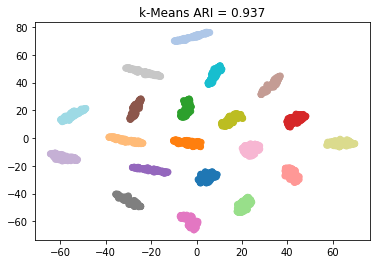

In [ ]:
clustering_analysis(
    SpikeSortingVAE,
    "experiments/vaes/vae_6latent/model.ckpt",
    templates,
    clusters
)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.003s...
[t-SNE] Computed neighbors for 2000 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 3.039425
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.010330
[t-SNE] KL divergence after 1000 iterations: 0.157567


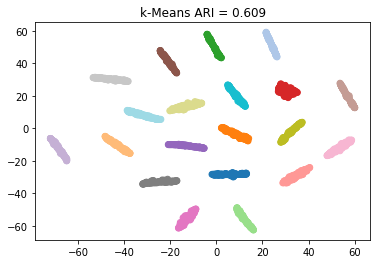

In [237]:
from sklearn.decomposition import IncrementalPCA

pca = IncrementalPCA(n_components=6)
reps = pca.fit_transform(templates.reshape(2000, -1))

km = KMeans(n_clusters=20, random_state=4995).fit(reps)
ari = adjusted_rand_score(km.labels_, clusters)

z = TSNE(n_components=2, verbose=1, random_state=4995).fit_transform(reps)
plt.figure()
plt.scatter(z[:, 0], z[:, 1], cmap="tab20", c=clusters)
plt.title(f"k-Means ARI = {ari:.3f}")
plt.savefig(f"visualizations/pca_clustering.png")